# Проект 5. Компьютер говорит «Нет»

## Описание задачи

В этом проекте решается задача банковского скоринга - принятие решения о том, выдавать или нет кредит заемщику, т.е. будет ли заёмщик проблемным или нет. Решение принимается по набору различных признаков для каждого клиента, таких как уровень дохода, наличие автомобиля, наличие загранпаспорта, уровень образования, количество отказанных прошлых заявок и прочие. Для принятия решений о новых клиентах используется модель, обученная на реальных данных о нескольких десятках тысяч клиентов, о которых известно, были ли они проблемными или нет. Таким образом, задача является бинарной классификацией, и может быть решена различными методами: логистической регрессией, методом опорных векторов, различными методами решающих деревьев, и простыми методами классификации (наивный байесовский классификатор и метод ближайших соседей). Основной метрикой соревнования на kaggle является ROC AUC Score, также проанализируем и другие метрики классификации (confusion matrix, accuracy, precision, recall, F1 score).


## Импорт библиотек, установка параметров, определение функций

In [1]:
import warnings
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import style
style.use('ggplot')
%matplotlib inline
warnings.filterwarnings('ignore')
from datetime import datetime
import scikitplot as skplt
from sklearn.model_selection import cross_val_score
from sklearn.metrics import auc, roc_auc_score, roc_curve, accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler

In [2]:
# функции, используемые в ноутбуке

def num_vis(column):
    fig = plt.figure(figsize=(14, 4))

    ax1 = fig.add_axes([0, 0.4, 0.45, 1])
    plt.title('Распределение признака '+column+' в train по типам заемщиков')
    sns.histplot(data=train[column], x=train[column], hue=train['default'])
    plt.legend(['negative', 'positive'])

    ax2 = fig.add_axes([0, 0, 0.45, 0.25])
    sns.boxplot(y='default', x=column,
                data=train[train['Train'] == 1], orient='h', saturation=0.5)

    ax3 = fig.add_axes([0.55, 0.4, 0.45, 1])
    plt.title('Распределение признака '+column+' в двух датасетах')
    sns.histplot(data=data[column], x=data[column], hue=data['Train'])
    plt.legend(['train', 'test'])

    ax4 = fig.add_axes([0.55, 0, 0.45, 0.25])
    sns.boxplot(y='Train', x=column, data=data, orient='h', saturation=0.5)

    plt.tight_layout()


def num_vis_log(column):
    fig = plt.figure(figsize=(14, 4))

    ax1 = fig.add_axes([0.55, 0.4, 0.45, 1])
    plt.title('Распределение прологарифмированного признака ' +
              column+' в двух датасетах')
    sns.histplot(data=data[column], x=data[column], hue=data['Train'])
    plt.legend(['train', 'test'])

    ax2 = fig.add_axes([0.55, 0, 0.45, 0.25])
    sns.boxplot(y='Train', x=column, data=data, orient='h', saturation=0.5)

    plt.tight_layout()


def cat_vis(column):
    fig = plt.figure(figsize=(14, 4))
    
    ax1 = fig.add_axes([0, 0, 0.8, 1])
    plt.title('Соотношение типов клиентов по категориям '+column)
    ax = sns.countplot(x=column, hue="default", data=train)
    num = len(train[column].value_counts())
    a = [p.get_height() for p in ax.patches]
    patch = [p for p in ax.patches]
    for i in range(num):
        for j in range(2):
            percentage = '{:.1f}%'.format(100 * a[(j*num + i)]/(a[i]+a[i+num]))
            x = patch[(j*num + i)].get_x() + patch[(j*num + i)].get_width() / 2 - 0.15
            y = patch[(j*num + i)].get_y() + patch[(j*num + i)].get_height() 
            ax.annotate(percentage, (x, y), size = 12)
    plt.show()
    
    ax2 = fig.add_axes([0, 0, 0.5, 1])
    data[column].value_counts().plot.bar()
    plt.title('Распределение признака '+column+' по категориям')

    plt.tight_layout()

# Импорт данных и предварительный анализ

In [3]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
pd.set_option('display.max_columns', None)
print('Размерность тренировочного датасета: ', train.shape)
display(train.head())
print('Размерность тестового датасета: ', test.shape)
display(test.head())

Размерность тренировочного датасета:  (73799, 19)


,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,default
0,25905,01FEB2014,SCH,M,62,Y,Y,0,0,-2.008753,1,50,1,2,18000,4,1,N,0
1,63161,12MAR2014,SCH,F,59,N,N,0,0,-1.532276,3,50,2,3,19000,4,1,N,0
2,25887,01FEB2014,SCH,M,25,Y,N,2,0,-1.408142,1,80,1,2,30000,1,4,Y,0
3,16222,23JAN2014,SCH,F,53,N,N,0,0,-2.057471,2,50,2,3,10000,1,3,N,0
4,101655,18APR2014,GRD,M,48,N,N,0,1,-1.244723,1,60,2,3,30000,1,4,Y,0


Размерность тестового датасета:  (36349, 18)


,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport
0,74835,22MAR2014,GRD,M,29,Y,Y,0,0,-2.271884,3,50,1,2,50000,1,4,N
1,17527,24JAN2014,SCH,F,39,N,N,5,0,-1.504999,2,50,1,2,5000,4,3,N
2,75683,23MAR2014,UGR,M,50,Y,Y,0,0,-1.691339,1,50,1,2,30000,1,3,Y
3,26883,03FEB2014,SCH,M,56,N,N,0,0,-2.374182,1,40,1,2,17000,1,3,N
4,28862,04FEB2014,GRD,F,38,N,N,0,0,-2.487502,0,80,2,3,120000,1,3,N


In [4]:
# Для обработки признаков объединяем тренировочный и тестовый в один датасет

train['Train'] = 1 # помечаем где у нас тренировочный
test['Train'] = 0 # помечаем где у нас тестовый

data = train.append(test, sort=False).reset_index(drop=True) # объединяем
data

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,default,Train
0,25905,01FEB2014,SCH,M,62,Y,Y,0,0,-2.008753,1,50,1,2,18000,4,1,N,0.0,1
1,63161,12MAR2014,SCH,F,59,N,N,0,0,-1.532276,3,50,2,3,19000,4,1,N,0.0,1
2,25887,01FEB2014,SCH,M,25,Y,N,2,0,-1.408142,1,80,1,2,30000,1,4,Y,0.0,1
3,16222,23JAN2014,SCH,F,53,N,N,0,0,-2.057471,2,50,2,3,10000,1,3,N,0.0,1
4,101655,18APR2014,GRD,M,48,N,N,0,1,-1.244723,1,60,2,3,30000,1,4,Y,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110143,83775,31MAR2014,SCH,F,37,N,N,1,0,-1.744976,3,50,2,3,15000,4,1,N,NaN,0
110144,106254,25APR2014,GRD,F,64,Y,Y,0,0,-2.293781,3,60,1,2,200000,1,4,N,NaN,0
110145,81852,30MAR2014,GRD,M,31,N,N,2,0,-0.940752,1,50,1,2,60000,4,2,N,NaN,0
110146,1971,07JAN2014,UGR,F,27,N,N,1,0,-1.242392,2,80,2,3,30000,1,1,N,NaN,0


In [5]:
# выведем сводную информацию по датасету:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110148 entries, 0 to 110147
Data columns (total 20 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   client_id         110148 non-null  int64  
 1   app_date          110148 non-null  object 
 2   education         109670 non-null  object 
 3   sex               110148 non-null  object 
 4   age               110148 non-null  int64  
 5   car               110148 non-null  object 
 6   car_type          110148 non-null  object 
 7   decline_app_cnt   110148 non-null  int64  
 8   good_work         110148 non-null  int64  
 9   score_bki         110148 non-null  float64
 10  bki_request_cnt   110148 non-null  int64  
 11  region_rating     110148 non-null  int64  
 12  home_address      110148 non-null  int64  
 13  work_address      110148 non-null  int64  
 14  income            110148 non-null  int64  
 15  sna               110148 non-null  int64  
 16  first_time        11

In [6]:
# информация о пропусках в данных
data.isna().sum()

client_id               0
app_date                0
education             478
sex                     0
age                     0
car                     0
car_type                0
decline_app_cnt         0
good_work               0
score_bki               0
bki_request_cnt         0
region_rating           0
home_address            0
work_address            0
income                  0
sna                     0
first_time              0
foreign_passport        0
default             36349
Train                   0
dtype: int64

Описание данных:

 - client_id - идентификатор клиента
 - education - уровень образования
 - sex - пол заемщика
 - age - возраст заемщика
 - car - флаг наличия автомобиля
 - car_type - флаг автомобиля иномарки
 - decline_app_cnt - количество отказанных прошлых заявок
 - good_work - флаг наличия “хорошей” работы
 - bki_request_cnt - количество запросов в БКИ
 - home_address - категоризатор домашнего адреса
 - work_address - категоризатор рабочего адреса
 - income - доход заемщика
 - foreign_passport - наличие загранпаспорта
 - sna - связь заемщика с клиентами банка
 - first_time - давность наличия информации о заемщике
 - score_bki - скоринговый балл по данным из БКИ
 - region_rating - рейтинг региона
 - app_date - дата подачи заявки
 - default - флаг дефолта по кредиту

Резюме: в тренировочной выборке 73799 клиентов, в тестовой выборке - 36349. Всего данные о 110148 клиентах. Всего пропусков 478, все пропуски в переменной "education". Всего 19 признаков: из них 1 - временной ряд, 5 бинарных, 6 категориальных и 5 числовых, "client_id" - уникальный числовой признак (не несет пользы при анализе) и наша целевая переменная "default". Также искуственно добавленный признак тренировочной части датасета Train.

Посмотрим на распределение целевой переменной.

<AxesSubplot:>

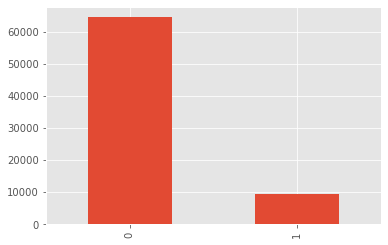

In [7]:
train['default'].value_counts().plot.bar()

Выборка распределена неравномерно, недефолтных клиентов намного больше.

In [8]:
# создадим списки с типами признаков:
# временной ряд (1)
time_cols = ['app_date']
# бинарные переменные (5)
bin_cols = ['sex', 'car', 'car_type', 'good_work', 'foreign_passport']
# категориальные переменные (6)
cat_cols = ['education', 'region_rating',
            'home_address', 'work_address', 'sna', 'first_time']
# числовые переменные (5)
num_cols = ['age', 'decline_app_cnt', 'score_bki', 'bki_request_cnt', 'income']

# EDA

## Анализ числовых переменных

### 1. Age - возраст

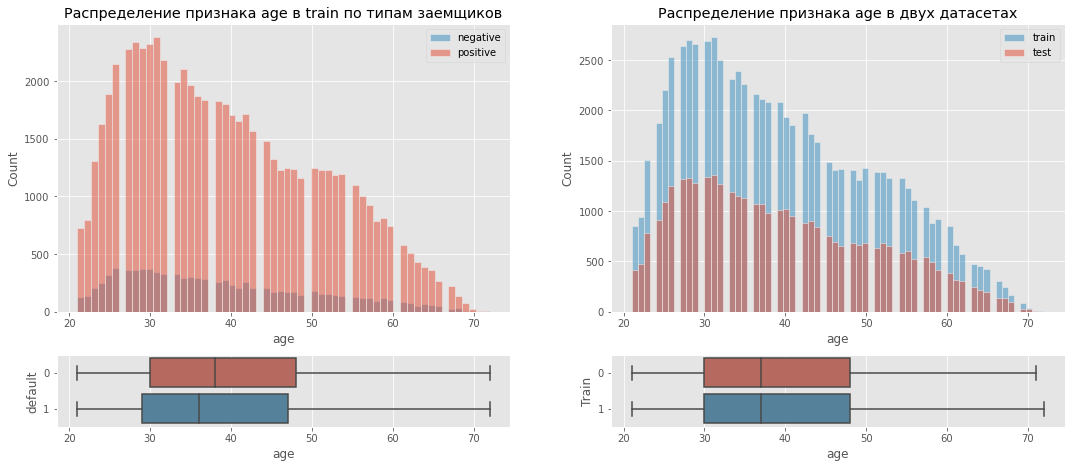

In [9]:
num_vis('age')

In [10]:
data['age'] = np.log(data['age'] + 1)

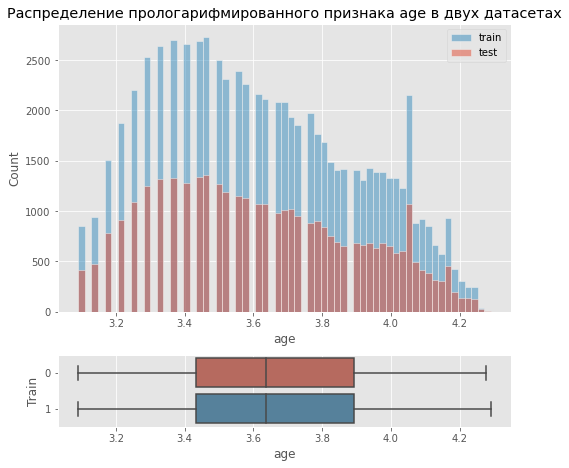

In [11]:
num_vis_log('age')

#### Резюме : Распределение логнормальное, выбросов нет. Дефолтные клиенты в среднем более молодого возраста, но ненамного.

### 2. decline_app_cnt - количество отказанных прошлых заявок

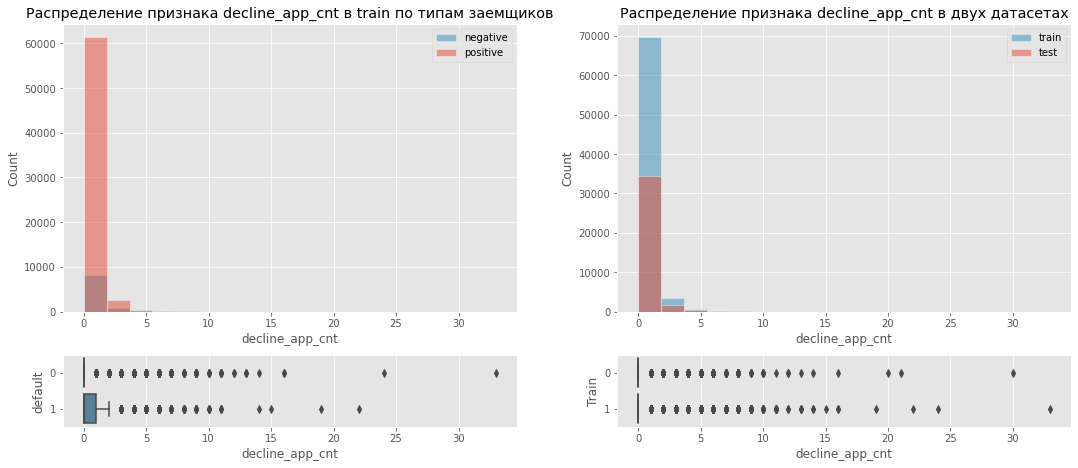

In [12]:
num_vis('decline_app_cnt')

#### Резюме: распределение логнормальное, выбросов очень много, поэтому удалять их пока не будем. Признак прологарифмируем. Дефолтные клиенты в среднем имеют большее количество отмененных заявок.

In [13]:
data['decline_app_cnt'] = np.log(data['decline_app_cnt'] + 1)

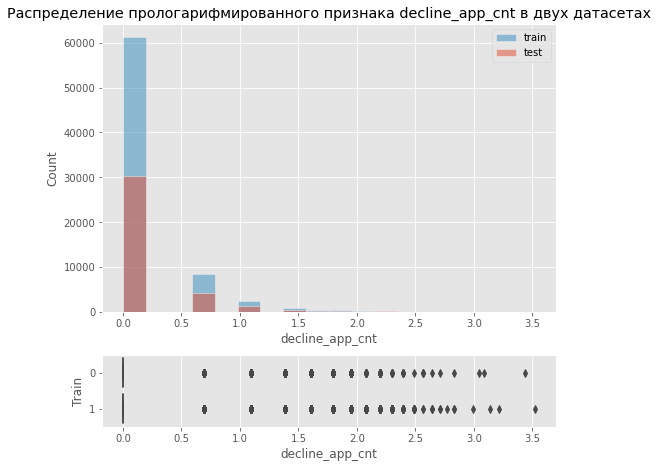

In [14]:
num_vis_log('decline_app_cnt')

### 3. score_bki - скоринговый балл по данным из БКИ

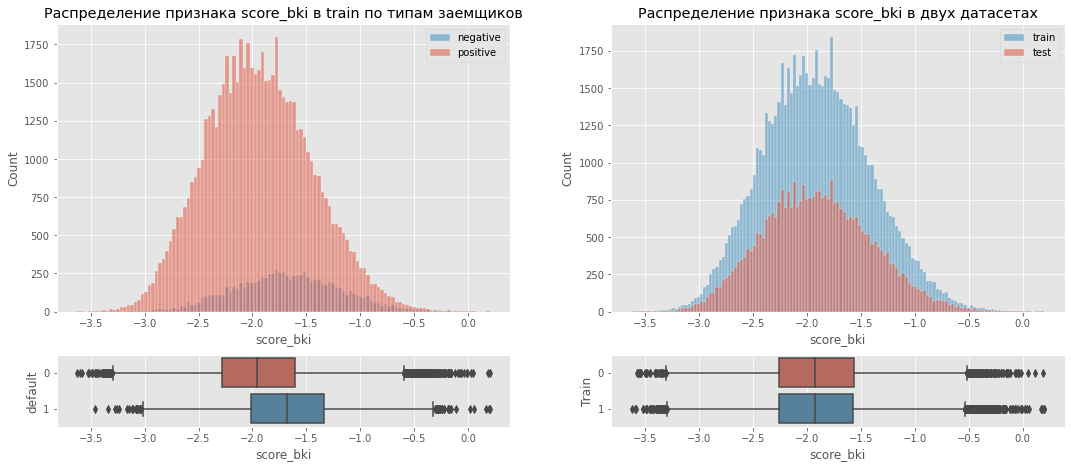

In [15]:
num_vis('score_bki')

#### Резюме: распределение нормальное, выбросов не много, оставим. По распределению признака можно сделать вывод, что дефолтные клиенты в среднем имеют скоринговый балл выше.

### 4. bki_request_cnt - количество запросов в БКИ

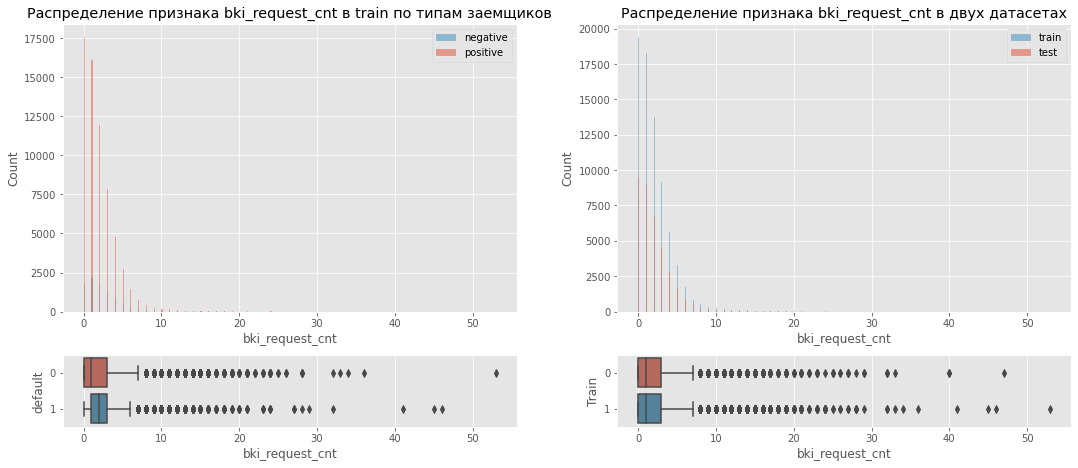

In [16]:
num_vis('bki_request_cnt')

#### Резюме: распределение логнормальное, выбросов очень много, поэтому удалять их пока не будем. Признак прологарифмируем, чтобы уменьшить количество выбросов и добиться более нормального распределения.

In [17]:
data['bki_request_cnt'] = np.log(data['bki_request_cnt'] + 1)

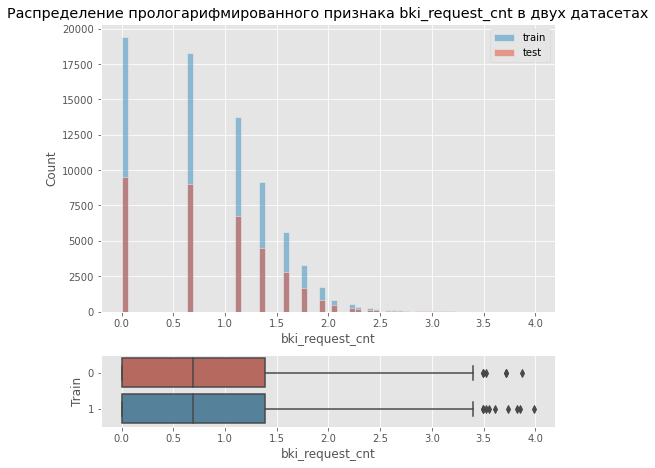

In [18]:
num_vis_log('bki_request_cnt')

### 5. income - доход заемщика

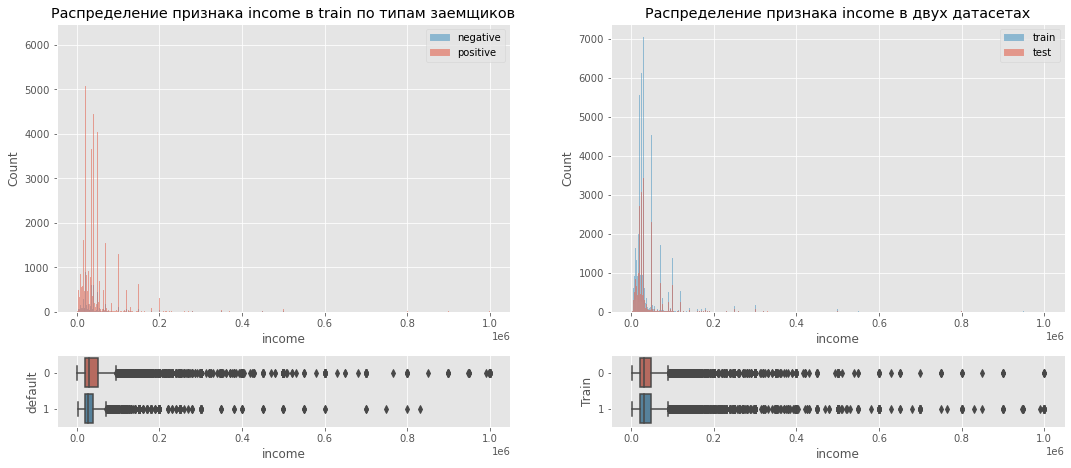

In [19]:
num_vis('income')

#### Резюме: распределение логнормальное, выбросов много, удалять не будем. Признак прологарифмируем, чтобы уменьшить количество выбросов и добиться более нормального распределения. Дефолтные клиенты в среднем имеют более низкий доход.

In [20]:
data['income'] = np.log(data['income'] + 1)

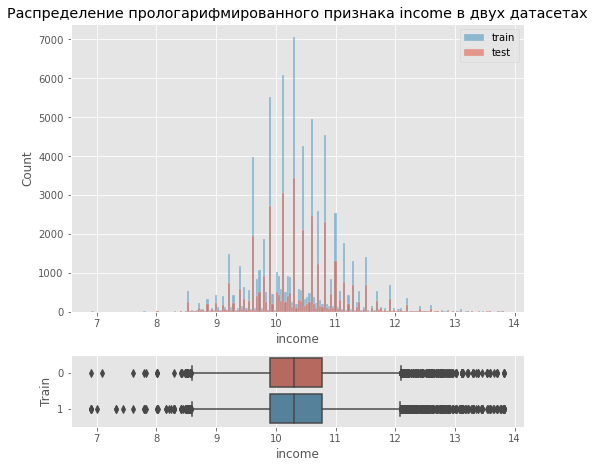

In [21]:
num_vis_log('income')

## Анализ категориальных переменных

### 6. education - уровень образования

В данном признаке имеются пропуски. Пропуски заменим на значения, которые встречаются чаще всего.

In [22]:
data['education'].value_counts()

SCH    57998
GRD    34768
UGR    14748
PGR     1865
ACD      291
Name: education, dtype: int64

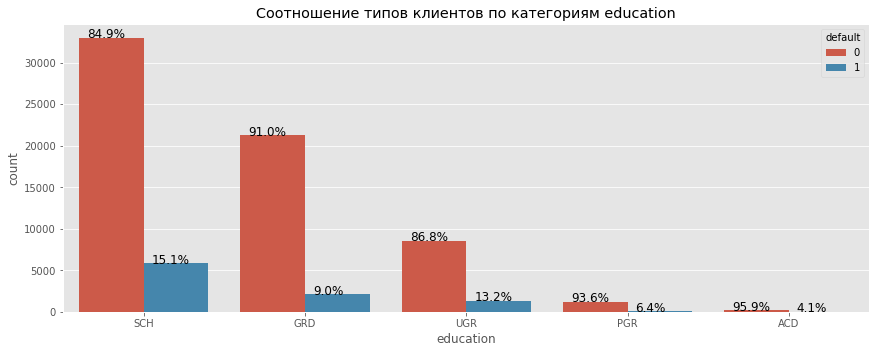

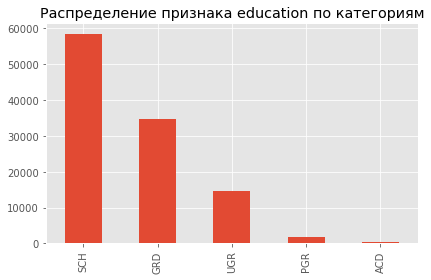

In [23]:
data['education'] = data['education'].fillna('SCH')
cat_vis('education')

#### Резюме: Самые ненадежные заемщики те, кто еще учится. Таких клиентов больше всех в датасете. Далее по надежности идут окончившие школу. Более надежными становятся заемщики, получающие высшее образование, самые надежныете, кто получил ученую степень.

### 7. region_rating - рейтинг региона

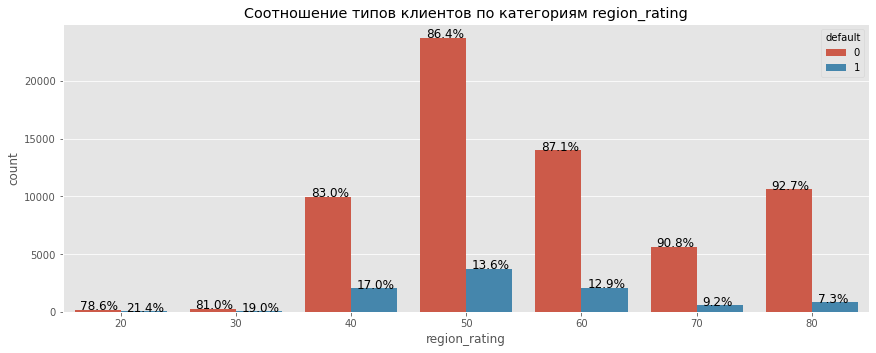

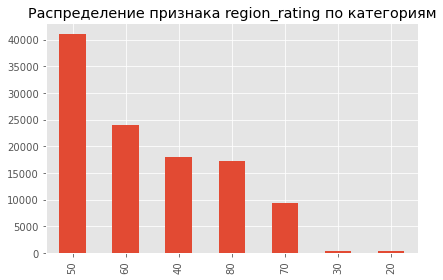

In [24]:
cat_vis('region_rating')

#### Резюме: надежность заемщика напрямую связан с рейтингом региона. Чем выше рейтинг района, тем меньше дефолтных клиентов. Это очень хорошо заметно на графике с процентным соотношением.

### 8. home_address - категоризатор домашнего адреса

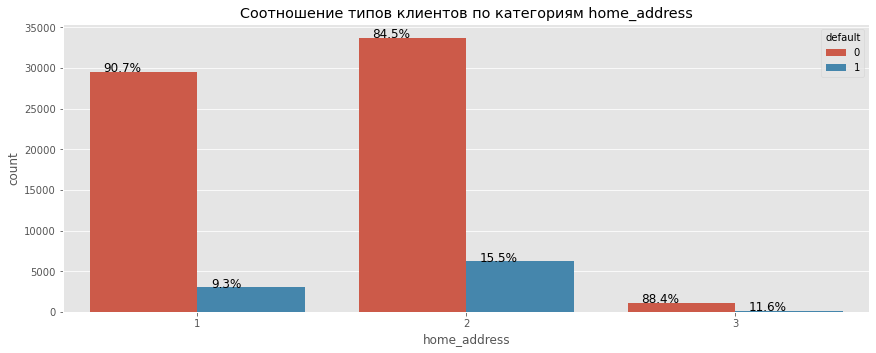

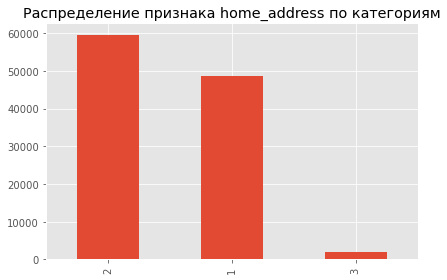

In [25]:
cat_vis('home_address')

#### Резюме: большинство клиентов распределены в двух категориях - 1 и 2. В этих двух категориях разница в долях дефолтных клиентов небольшая, но есть.

### 9. work_address - категоризатор рабочего адреса

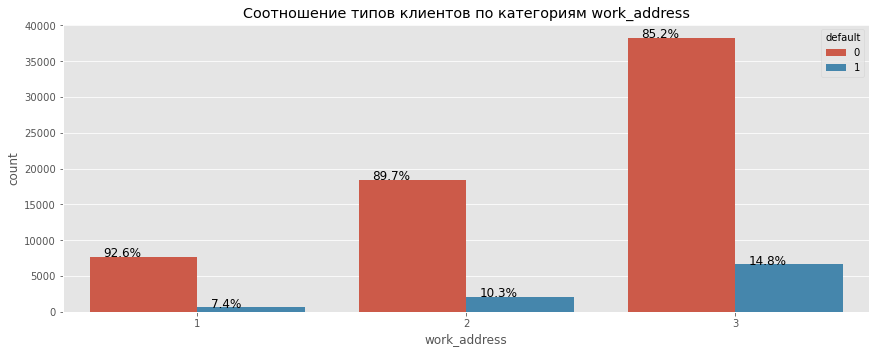

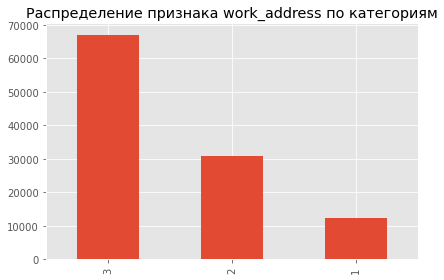

In [26]:
cat_vis('work_address')

#### Резюме: распределение ненадежных клиентов пропорциональна количеству клиентов в каждой категории.

### 10. sna - связь заемщика с клиентами банка

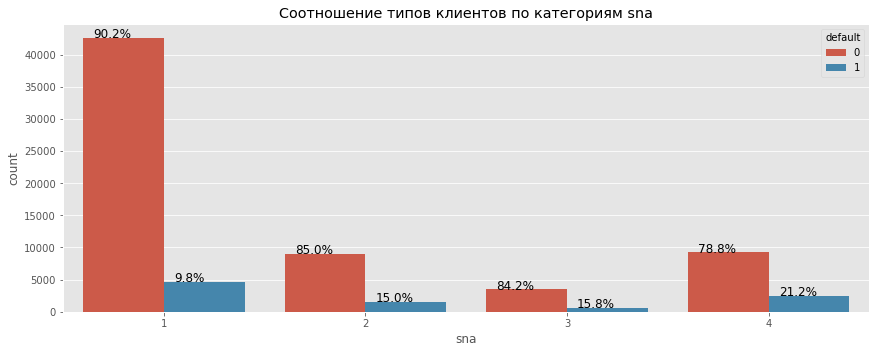

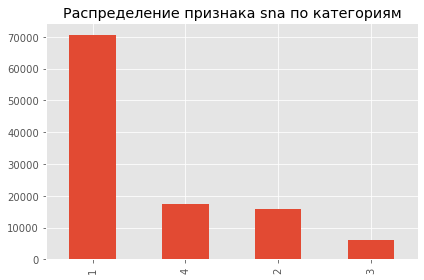

In [27]:
cat_vis('sna')

#### Резюме: чем выше показатель признака, тем выше доля ненадежных клиентов.

### 11. first_time - давность наличия информации о заемщике

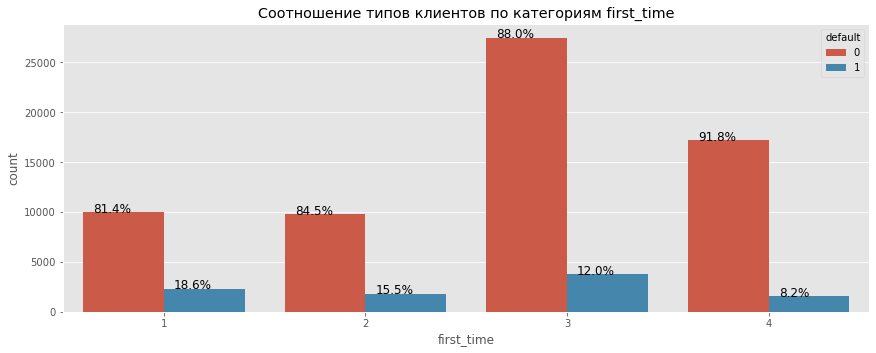

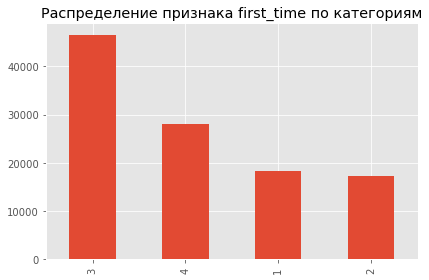

In [28]:
cat_vis('first_time')

#### Резюме: чем ниже показатель признака, тем выше доля ненадежных клиентов.

## Анализ бинарных переменных

### 12. sex - пол заемщика

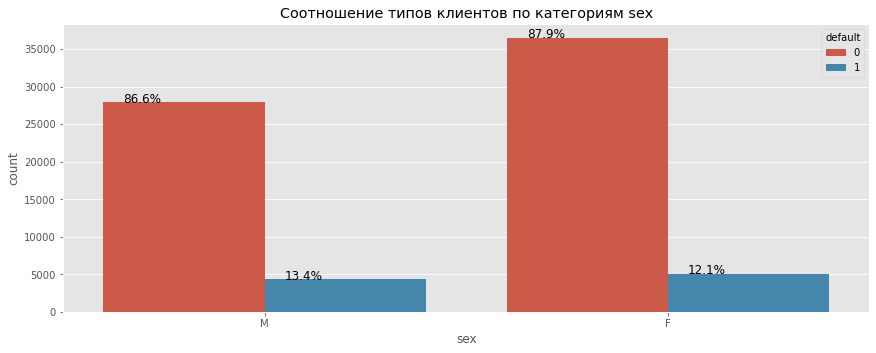

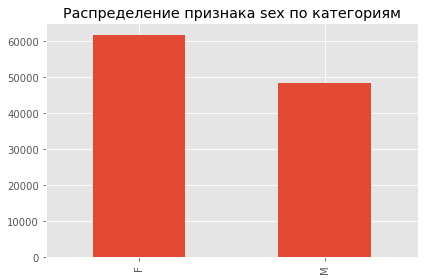

In [29]:
cat_vis('sex')

#### Резюме: показатель дефолтных клиентов примерно одинаков, а клиентов-женщин в датасете примерно на 25% больше, чем клиентов-мужчин.

### 13. car - флаг наличия автомобиля

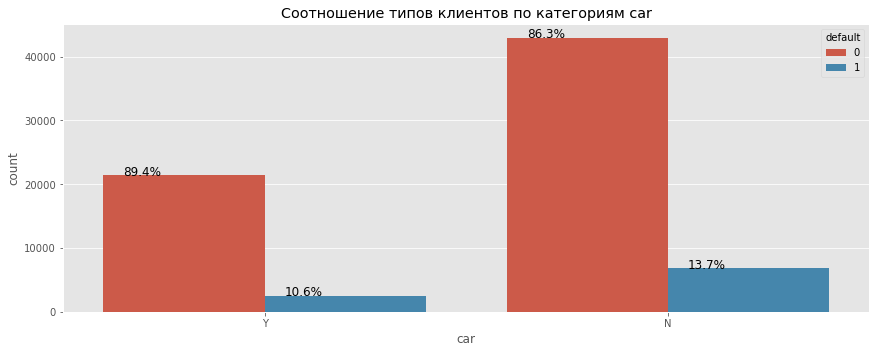

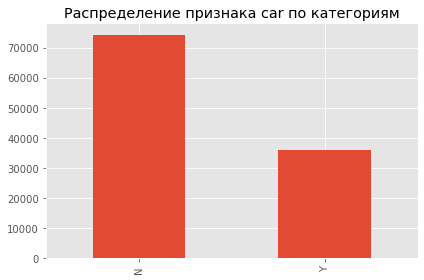

In [30]:
cat_vis('car')

#### Резюме: заемщики, у которых в наличии есть автомобиль, более надежные.

### 14. car_type - флаг автомобиля иномарки

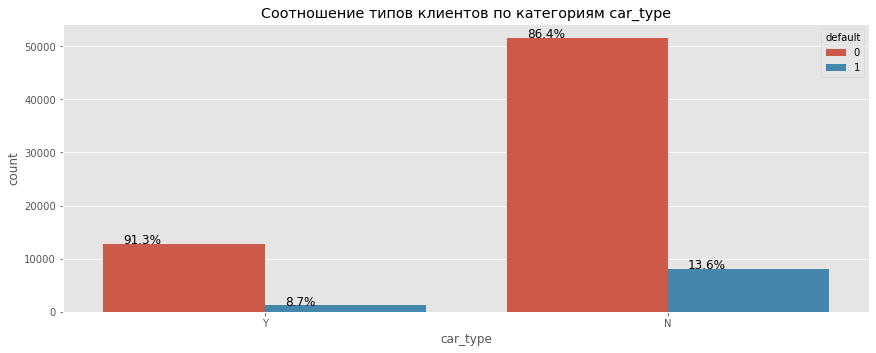

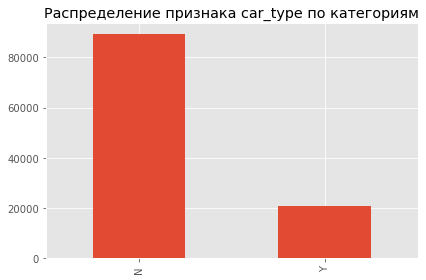

In [31]:
cat_vis('car_type')

#### Резюме: такая же история как и с наличием автомобиля. Клиенты с автомобилем-иномаркой, чаще возвращают кредит.

### 15. good_work - флаг наличия “хорошей” работы

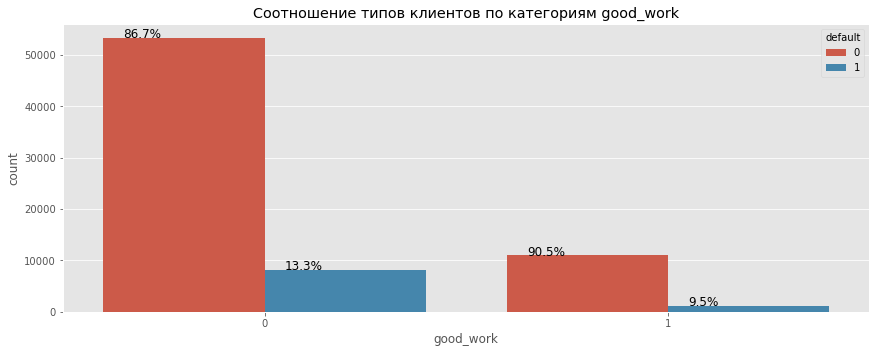

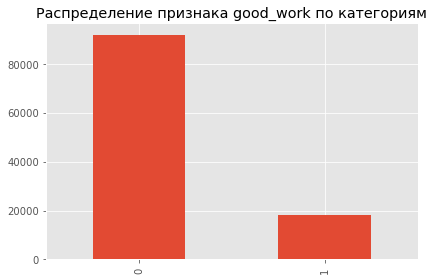

In [32]:
cat_vis('good_work')

#### Резюме: Клиентов с хорошей работой намного меньше, и они чаще возвращают кредит.

### 16. foreign_passport - наличие загранпаспорта

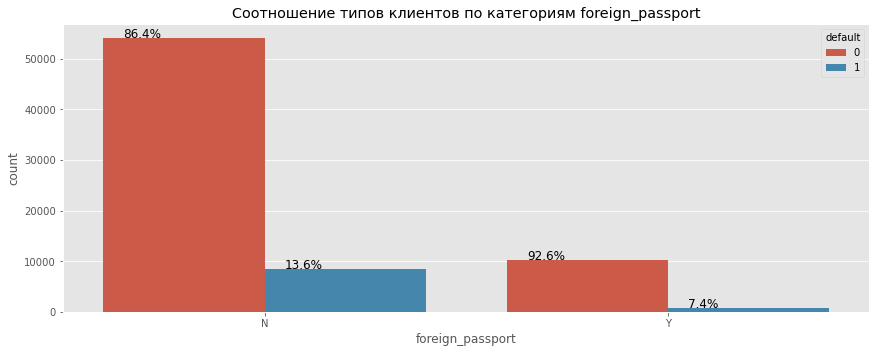

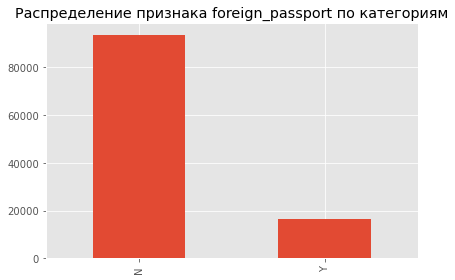

In [33]:
cat_vis('foreign_passport')

#### Резюме: такая же ситуация как и с наличием "хорошей" работы.  Клиенты с наличием загранпаспорта меньше берут кредиты и чаще его возвращают.

## Анализ временной переменной

### 17. app_date - дата подачи заявки

In [34]:
# Преобразуем формат признака
data.app_date = pd.to_datetime(data.app_date, format='%d%b%Y')
# начало и конец периода нашего датасета
start = data.app_date.min()
end = data.app_date.max()
print(start, end)

2014-01-01 00:00:00 2014-04-30 00:00:00


In [35]:
# Вводим новый признак - номер дня с 1 января
data['days'] = (data.app_date - start).dt.days.astype('int')

## Feature engineering - генерация новых признаков

In [36]:
# Преобразуем бинарные признаки в числовые с помощью LabelEncoder
bin_cols_lable = {}
label_encoder = LabelEncoder()
for col in bin_cols:
    data[col] = label_encoder.fit_transform(data[col])
    bin_cols_lable[col] = dict(enumerate(label_encoder.classes_))
print(bin_cols_lable)

{'sex': {0: 'F', 1: 'M'}, 'car': {0: 'N', 1: 'Y'}, 'car_type': {0: 'N', 1: 'Y'}, 'good_work': {0: 0, 1: 1}, 'foreign_passport': {0: 'N', 1: 'Y'}}


In [37]:
# Новые признаки
max_income = data.groupby('age')['income'].max().to_dict()
data['sign_1'] = data['age'].map(max_income)

mean_income_region = data.groupby('region_rating')['income'].mean().to_dict()
data['sign_2'] = data['region_rating'].map(mean_income_region)

data['sign_3'] = data.income / data.region_rating

data['sign_4'] = data.income / (data.bki_request_cnt + 1)

data['sign_5'] = (data.decline_app_cnt * data.sna) ** 2

data['sign_6'] = data.region_rating * data.car

data['sign_7'] = (data.car + data.car_type) / data.sna * data.decline_app_cnt

data['sign_8'] = data.home_address + data.work_address

data['sign_9'] = data.income**2 / \
    (data.region_rating * (data.decline_app_cnt + 1))

data['sign_10'] = data.first_time * data.sna / (data.bki_request_cnt + 1)

data['sign_11'] = (data.score_bki / data.age) ** data.foreign_passport

data['sign_12'] = (data.score_bki / data.age) ** data.sna

data['sign_13'] = data.age / data.score_bki

data['sign_14'] = data.good_work * (data.home_address + data.work_address)

data['sign_15'] = (data.home_address + data.work_address) * data.sna

data['sign_16'] = data.decline_app_cnt * data.sna

mean_income_age = data.groupby('age').income.mean().to_dict()
data['sign_17'] = abs(
    (data.income - data.age.map(mean_income_age))/data['age'].map(max_income))

mean_bki = data.groupby('age')['bki_request_cnt'].mean().to_dict()
data['sign_18'] = data['age'].map(mean_bki)

data['sign_19'] = (data.bki_request_cnt != 0).astype(int)

data['sign_20'] = (data.decline_app_cnt == 0).astype(int)

data['sign_21'] = data.client_id.lt(10000).astype(int)
data['sign_22'] = data.client_id.between(10000, 90000).astype(int)

data['sign_23'] = np.log(data.decline_app_cnt/data.client_id + 1)

data['sign_24'] = np.log((data.income/data.age)+1)

edu_dict = {'SCH': 1, 'UGR': 2, 'GRD': 3, 'PGR': 4, 'ACD': 5}
edu = data.education.fillna(data.education.mode()[0]).map(edu_dict)
data['sign_25'] = np.log((edu/data.age)+1)

new_num = list(data.columns[data.columns.str.contains('sign')])

In [38]:
data.sample(5)

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,default,Train,days,sign_1,sign_2,sign_3,sign_4,sign_5,sign_6,sign_7,sign_8,sign_9,sign_10,sign_11,sign_12,sign_13,sign_14,sign_15,sign_16,sign_17,sign_18,sign_19,sign_20,sign_21,sign_22,sign_23,sign_24,sign_25
8880,40239,2014-02-17,GRD,0,3.555348,0,0,0.000000,0,-2.225004,0.000000,40,1,2,9.615872,2,2,1,0.0,1,47,13.815512,10.158123,0.240397,9.615872,0.000000,0,0.0,3,2.311625,4.000000,-0.625819,0.391649,-1.597907,0,6,0.000000,0.059972,0.877781,0,1,0,1,0.000000,1.309581,0.611828
39230,6605,2014-01-13,SCH,1,3.178054,0,0,0.693147,0,-1.783732,1.098612,80,2,3,10.819798,1,3,1,0.0,1,12,12.676079,10.784262,0.135247,5.155692,0.480453,0,0.0,5,0.864278,1.429516,-0.561266,-0.561266,-1.781688,0,5,0.693147,0.045540,0.781520,1,0,1,0,0.000105,1.482635,0.273577
77152,28687,2014-02-04,SCH,0,4.174387,0,0,0.693147,0,-2.760859,0.000000,50,2,3,8.839422,2,3,0,NaN,0,34,13.384729,10.208090,0.176788,8.839422,1.921812,0,0.0,5,0.922960,6.000000,1.000000,0.437424,-1.511989,0,10,1.386294,0.073150,0.912570,0,0,0,1,0.000024,1.137043,0.214753
47160,39588,2014-02-15,GRD,1,4.094345,1,0,0.000000,0,-1.901291,0.000000,80,2,3,10.915107,1,3,1,0.0,1,45,13.764218,10.784262,0.136439,10.915107,0.000000,80,0.0,5,1.489244,3.000000,-0.464370,-0.464370,-2.153455,0,5,0.000000,0.066666,0.914524,0,1,0,1,0.000000,1.299073,0.549691
106648,89232,2014-04-05,UGR,1,3.258097,0,0,0.693147,1,-1.474676,1.386294,60,2,3,10.239996,4,1,0,NaN,0,94,13.304687,10.278314,0.170667,4.291170,7.687248,0,0.0,5,1.032176,1.676239,1.000000,0.041969,-2.209364,5,20,2.772589,0.004913,0.828157,1,0,0,1,0.000008,1.421405,0.478626


## Нормализация данных

In [39]:
num_cols = ['age', 'decline_app_cnt', 'bki_request_cnt', 'income', 'days']
scaler = StandardScaler()
for col in num_cols:
    data[col] = scaler.fit_transform(data[[col]])
for col in new_num:
    data[col] = scaler.fit_transform(data[[col]])

In [40]:
# Преобразуем категориальные признаки
data=pd.get_dummies(data, prefix=cat_cols, columns=cat_cols)
data.head()

,client_id,app_date,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,income,foreign_passport,default,Train,days,sign_1,sign_2,sign_3,sign_4,sign_5,sign_6,sign_7,sign_8,sign_9,sign_10,sign_11,sign_12,sign_13,sign_14,sign_15,sign_16,sign_17,sign_18,sign_19,sign_20,sign_21,sign_22,sign_23,sign_24,sign_25,education_ACD,education_GRD,education_PGR,education_SCH,education_UGR,region_rating_20,region_rating_30,region_rating_40,region_rating_50,region_rating_60,region_rating_70,region_rating_80,home_address_1,home_address_2,home_address_3,work_address_1,work_address_2,work_address_3,sna_1,sna_2,sna_3,sna_4,first_time_1,first_time_2,first_time_3,first_time_4
0,25905,2014-02-01,1,1.714029,1,1,-0.418815,0,-2.008753,-0.281790,-0.786080,0,0.0,1,-0.934391,-2.296030,-0.587943,0.105112,-0.215311,-0.199072,1.104695,-0.185170,-0.948864,0.172040,-0.104565,0.416500,0.969051,0.019934,-0.424894,0.871743,-0.342548,-0.895842,0.226195,0.596519,0.451868,-0.315977,0.613867,-0.023902,-1.661683,-1.020512,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,1,1,0,0,0
1,63161,2014-03-12,0,1.542867,0,0,-0.418815,0,-1.532276,0.770563,-0.708472,0,0.0,1,0.281474,0.654775,-0.587943,0.129718,-0.865709,-0.199072,-0.668956,-0.185170,0.820066,0.209797,-0.472532,0.416500,0.869161,-0.214803,-0.424894,2.326493,-0.342548,-0.862382,0.359502,0.596519,0.451868,-0.315977,0.613867,-0.023902,-1.507118,-1.007192,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,1,1,0,0,0
2,25887,2014-02-01,1,-1.390791,1,0,2.621662,0,-1.408142,-0.281790,-0.052834,1,0.0,1,-0.934391,-0.521607,1.872131,-1.421836,-0.096985,0.100990,2.168885,4.050438,-0.948864,-2.115094,-0.104565,-2.193112,-0.397107,-0.076812,-0.424894,-0.764850,0.955208,-1.180574,-0.508472,0.596519,-2.213034,-0.315977,0.613867,0.042369,1.032767,-0.724277,0,0,0,1,0,0,0,0,0,0,0,1,1,0,0,0,1,0,1,0,0,0,0,0,0,1
3,16222,2014-01-23,0,1.173250,0,0,-0.418815,0,-2.057471,0.333797,-1.629771,0,0.0,1,-1.214975,0.786083,-0.587943,-0.162379,-0.763678,-0.199072,-0.668956,-0.185170,0.820066,-0.225018,-0.604829,0.416500,-0.631381,0.067596,-0.424894,-0.401163,-0.342548,1.250336,0.608238,0.596519,0.451868,-0.315977,0.613867,-0.023902,-1.873694,-0.977428,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,1,1,0,0,0,0,0,1,0
4,101655,2014-04-18,1,0.832388,0,0,-0.418815,1,-1.244723,-0.281790,-0.052834,1,0.0,1,1.434987,0.516365,-0.288111,-0.444378,-0.096985,-0.199072,-0.668956,-0.185170,0.820066,-0.092438,-0.104565,-1.988367,-0.082183,-0.389871,2.749057,-0.401163,-0.342548,-0.951625,0.686752,0.596519,0.451868,-0.315977,-1.629017,-0.023902,-0.637288,1.024153,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,1,0,0,0,0,0,0,1


In [41]:
data.corr()

,client_id,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,income,foreign_passport,default,Train,days,sign_1,sign_2,sign_3,sign_4,sign_5,sign_6,sign_7,sign_8,sign_9,sign_10,sign_11,sign_12,sign_13,sign_14,sign_15,sign_16,sign_17,sign_18,sign_19,sign_20,sign_21,sign_22,sign_23,sign_24,sign_25,education_ACD,education_GRD,education_PGR,education_SCH,education_UGR,region_rating_20,region_rating_30,region_rating_40,region_rating_50,region_rating_60,region_rating_70,region_rating_80,home_address_1,home_address_2,home_address_3,work_address_1,work_address_2,work_address_3,sna_1,sna_2,sna_3,sna_4,first_time_1,first_time_2,first_time_3,first_time_4
client_id,1.000000,-0.033333,0.017342,-0.022271,-0.024695,-0.022520,0.003447,-0.061653,-0.008626,0.002900,-0.013739,-0.039242,0.002844,0.999581,0.012402,0.003766,-0.005449,-0.005555,-0.015603,-0.018697,-0.014065,0.175770,0.009720,-0.006657,0.011194,-0.018508,0.015063,0.022398,0.053947,-0.020644,-0.021052,0.004893,0.019764,0.018923,-0.497606,-0.259976,-0.033968,-0.010502,0.039254,-0.000222,0.031792,-0.002091,-0.050430,0.031338,0.003024,-0.004653,-0.008062,0.003060,0.001381,-0.002338,0.004711,-0.182347,0.190167,-0.032556,-0.078084,-0.140950,0.179965,0.006758,-0.010024,-0.003767,0.003123,0.009287,-0.021229,-0.024239,0.037276
sex,-0.033333,1.000000,-0.125320,0.277470,0.224822,0.022335,-0.044026,-0.046214,-0.052160,0.305326,0.085924,0.019619,-0.005135,-0.033811,0.017899,0.109298,-0.015378,0.096435,0.015030,0.274942,0.082145,0.060607,0.041525,0.031825,-0.087830,-0.011802,0.019639,-0.031455,0.016261,0.021107,-0.017486,-0.016907,-0.032048,-0.021847,0.024731,-0.000830,0.002363,0.280514,0.052960,0.017238,0.022769,0.019994,-0.040150,0.017589,-0.023470,-0.012078,-0.051163,-0.043214,-0.006790,0.045934,0.087714,-0.036289,0.033477,0.010375,-0.062010,-0.022596,0.060769,-0.000473,0.008966,-0.004159,-0.005375,-0.015820,0.006459,-0.002517,0.010985
age,0.017342,-0.125320,1.000000,-0.031962,-0.029295,-0.128624,-0.069063,-0.109169,0.050241,-0.090734,-0.034717,-0.026119,0.003929,0.017643,0.298056,-0.088965,0.060129,-0.053927,-0.087063,-0.037085,-0.053832,-0.007026,0.104167,-0.052482,0.040026,-0.065669,-0.041595,-0.073901,-0.055338,-0.122227,0.106889,0.332570,0.023316,0.120007,-0.021402,-0.003079,-0.010726,-0.788412,-0.261061,0.005450,-0.062413,-0.002924,0.168590,-0.161594,0.013202,0.010450,0.048238,0.039828,-0.006008,-0.047201,-0.062900,-0.001058,-0.000375,0.005516,0.015808,-0.001708,-0.008624,0.104267,-0.082083,-0.065776,-0.016675,-0.024537,-0.082823,-0.016294,0.108566
car,-0.022271,0.277470,-0.031962,1.000000,0.698760,-0.039005,0.001565,-0.043080,-0.045470,0.323183,0.106893,-0.043161,-0.002382,-0.022468,0.063707,0.061221,0.033704,0.103386,-0.028734,0.962875,0.266528,-0.016380,0.122550,0.024427,-0.108384,-0.064872,0.017557,0.003193,-0.072363,-0.041725,0.081295,0.015274,-0.045058,0.039715,0.012132,0.013044,-0.003258,0.219433,0.134866,0.023503,0.109157,0.066957,-0.119598,-0.002624,-0.010881,-0.011222,-0.029880,-0.026220,0.001092,0.023280,0.049803,0.025902,-0.026069,0.000984,-0.004355,0.019000,-0.014662,0.064902,-0.008561,-0.018171,-0.065529,-0.079398,-0.022534,0.026573,0.056512
car_type,-0.024695,0.224822,-0.029295,0.698760,1.000000,-0.050902,0.016160,-0.042107,-0.016938,0.369761,0.145373,-0.057484,-0.003309,-0.024865,0.058026,0.114127,0.013581,0.090399,-0.037425,0.700693,0.232888,-0.004550,0.125400,0.007024,-0.147252,-0.077459,0.015941,0.019002,-0.079859,-0.053270,0.141800,0.016028,-0.033117,0.050693,0.015278,0.008852,-0.004821,0.245758,0.181260,0.033088,0.153081,0.086565,-0.157802,-0.015459,-0.011590,-0.011721,-0.032034,-0.051686,-0.024867,0.051977,0.093662,0.011631,-0.011246,-0.001336,-0.001172,-0.000149,0.000893,0.078137,-0.013672,-0.021906,-0.075641,-0.087207,-0.025082,0.024861,0.067254
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,..

In [42]:
# Удалим нечисловые признаки и признаки, которые экспериментально ухудшили модель:
data = data.drop(['app_date', 'education_GRD', 'good_work', 'region_rating_80',
                  'sna_3', 'home_address_2', 'education_ACD', 'sna_4'], axis=1)

# Построение модели

In [43]:
# Разбиваем датасет на тренировочный и тестовый
train_data = data.query('Train == 1').drop(['Train', 'client_id'], axis=1)
test_data = data.query('Train == 0').drop(
    ['Train', 'client_id', 'default'], axis=1)

y = train_data.default.values
X = train_data.drop(['default'], axis=1)

In [44]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42)

## Обучение модели

### LogisticRegression

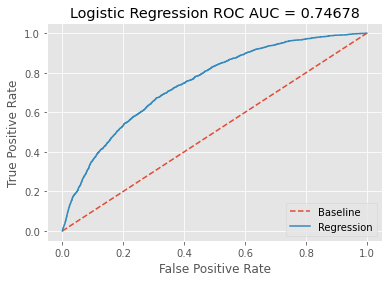

In [45]:
mod_lr = LogisticRegression(random_state=42)
mod_lr.fit(X_train, y_train)

y_pred_proba = mod_lr.predict_proba(X_test)[:, 1]

y_pred = mod_lr.predict(X_test)
fpr, tpr, threshold = roc_curve(y_test, y_pred_proba)
roc_auc = roc_auc_score(y_test, y_pred_proba)

plt.figure()
plt.plot([0, 1], label='Baseline', linestyle='--')
plt.plot(fpr, tpr, label='Regression')
plt.title('Logistic Regression ROC AUC = %0.5f' % roc_auc)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc='lower right')
plt.show()

In [46]:
print('accuracy_score:', accuracy_score(y_test, y_pred))
print('precision_score:', precision_score(y_test, y_pred))
print('recall_score:', recall_score(y_test, y_pred))
print('f1_score:', f1_score(y_test, y_pred))
print('roc_auc:', roc_auc_score(y_test, y_pred_proba))

accuracy_score: 0.8753387533875339
precision_score: 0.42857142857142855
recall_score: 0.021346469622331693
f1_score: 0.040667361835245046
roc_auc: 0.7467751251016195


<AxesSubplot:title={'center':'Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

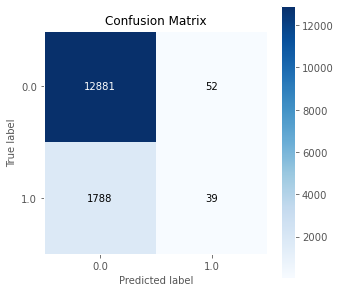

In [47]:
skplt.metrics.plot_confusion_matrix(y_test, y_pred, figsize=(5, 5))

#### Резюме: модель абсолютно не угадала дефолтных клиентов, тем самым обеспечили себе огромную ошибку второго рода и как следствие убыток, но ROC-AUC у нас высокий. Только метрика f1 сигнализирует о том, что что-то не впорядке. Попробуем сбалансировать параметры модели.

### Настройка гиперпараметров

In [48]:
# # Сетка параметров 
# C = [0.01, 0.05, 0.08, 0.1, 1, 10]
# penalty = ['l2']
# solver = ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
# class_weight = ['none', 'balanced']

# param = dict(penalty=penalty, solver=solver, class_weight=class_weight, C=C)

# gridsearch = GridSearchCV(mod_lr, param_grid=param, scoring='roc_auc', n_jobs=-1, cv=5)
# grid_result = gridsearch.fit(X_train, y_train)

# # Печать лучших параметров
# print('Best Score: ', grid_result.best_score_)
# print('Best Params: ', grid_result.best_params_)

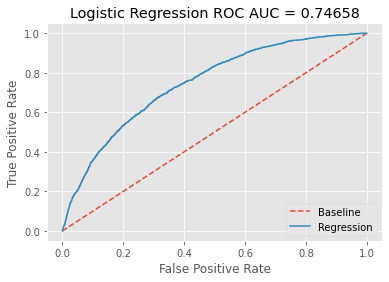

In [49]:
# модель после оптимизации
mod_lr = LogisticRegression(random_state=42, C=10, penalty='l2', class_weight={
                            1: 0.7, 0: 0.3}, solver='newton-cg', max_iter=1000)
mod_lr.fit(X_train, y_train)

y_pred_proba = mod_lr.predict_proba(X_test)[:, 1]

y_pred = mod_lr.predict(X_test)
fpr, tpr, threshold = roc_curve(y_test, y_pred_proba)
roc_auc = roc_auc_score(y_test, y_pred_proba)

plt.figure()
plt.plot([0, 1], label='Baseline', linestyle='--')
plt.plot(fpr, tpr, label='Regression')
plt.title('Logistic Regression ROC AUC = %0.5f' % roc_auc)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc='lower right')
plt.show()

In [50]:
print('accuracy_score:', accuracy_score(y_test, y_pred))
print('precision_score:', precision_score(y_test, y_pred))
print('recall_score:', recall_score(y_test, y_pred))
print('f1_score:', f1_score(y_test, y_pred))
print('roc_auc:', roc_auc_score(y_test, y_pred_proba))

accuracy_score: 0.8558943089430894
precision_score: 0.36187845303867405
recall_score: 0.21510673234811165
f1_score: 0.2698249227600412
roc_auc: 0.7465805726630083


<AxesSubplot:title={'center':'Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

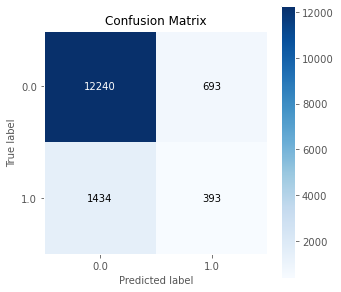

In [51]:
skplt.metrics.plot_confusion_matrix(y_test, y_pred, figsize=(5, 5))

#### Резюме: в случае с несбалансированной целевой переменной получаются низкие значения метрики f1-score. При этом возникает большое значение ошибок первого рода. Оптимизация гиперпараметров приводило матрицу к более адекватному виду и повышению метрики f1-score. Чаще всего гиперпараметры не оказывали сильного влияния на показатель roc auc.